# Explanation FINRL Proximal Policy Optimization (PPO) Trading Agent

This Jupyter notebook is designed to provide an overview of using [FinRL](https://github.com/AI4Finance-Foundation/FinRL) for **stock trading**, with a focus on the **Proximal Policy Optimization (PPO)** algorithm.

## Introduction

**FinRL** is an open-source library that provides implementations of state-of-the-art reinforcement learning algorithms for automated stock trading. It is designed to make it easy to develop, train, and use deep reinforcement learning models for trading.

## Notebook Content

In this notebook, we will walk through the process of setting up a trading environment, defining a trading strategy using PPO, training the model, and finally evaluating its performance. Furthermore, some details regarding the states and algorithms are provided. We hope this notebook serves as a useful guide 

### 1. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import sys
sys.path.append("../FINRL")

import itertools

c:\Users\TonVo\anaconda3\envs\myenv3.10\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

### 2. Get Data

Next, we get the data from FinRL's YahooDownloader. We will use the Dow 30 constituents as an example.

In [4]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2021-12-01'
TRADE_START_DATE = '2021-12-01'
TRADE_END_DATE = '2023-07-01'

In [5]:
df = YahooDownloader(start_date=TRAIN_START_DATE,
                     end_date=TRADE_END_DATE,
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [6]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.737892,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.193848,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941109,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.093405,7117200,CAT,4


### 3. Get Technical Indicators

In [7]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3647, 8)
Successfully added vix


### 4. Preprocess Data

In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [9]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.747390,746015200.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,2.747390,2.747390,39.189999
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,42.737892,6547900.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,42.737892,42.737892,39.189999
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.193848,10955700.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,15.193848,15.193848,39.189999
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941109,7010200.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,33.941109,33.941109,39.189999
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.093405,7117200.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,31.093405,31.093405,39.189999
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,8.505000,8.505000,39.189999
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.685611,40980600.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,11.685611,11.685611,39.189999
7,2009-01-02,CVX,74.230003,77.300003,73.580002,42.397469,13695900.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,42.397469,42.397469,39.189999
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.530584,9796600.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,20.530584,20.530584,39.189999
9,2009-01-02,GS,84.019997,87.620003,82.190002,67.604965,14088500.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,67.604965,67.604965,39.189999


In [10]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [11]:
train = data_split(processed_full,TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full,TRADE_START_DATE,TRADE_END_DATE)

### 5. State Space

In [12]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


To me I it wasn't immediately clear what the state space exactly looked like, but after going through the source code I found the following:

Let's denote the state at time $t$ as $S_t$. The state $S_t$ is a vector that includes the following elements:

1. $M_t$: The current portfolio value at time $t$.
2. $P_t = [p_{t,1}, p_{t,2}, ..., p_{t,n}]$: The closing prices of each of the $n$ stocks at time $t$.
3. $H_t = [h_{t,1}, h_{t,2}, ..., h_{t,n}]$: The number of shares of each of the $n$ stocks currently held at time $t$.
4. $I_t = [I_{t,1}, I_{t,2}, ..., I_{t,n}]$: The values of each of the $m$ technical indicators for each of the $n$ stocks at time $t$, where $I_{t,j} = [i_{t,j,1}, i_{t,j,2}, ..., i_{t,j,m}]$ for stock $j$.

So, we can represent the state $S_t$ as follows:

$$
S_t = [M_t, P_t, H_t, I_t]
$$

This representation assumes that there are multiple stocks. If there is only one stock, $P_t$, $H_t$, and $I_t$ would not be lists.

### 6. Environment

In [13]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

The `StockTradingEnv` class is initialized with the following parameters:

- $H_{\text{max}}$: Maximum number of shares to trade. In this case, $H_{\text{max}} = 100$.
- $M_{\text{initial}}$: Starting amount of money. In this case, $M_{\text{initial}} = 1000000$.
- $H = [h_1, h_2, ..., h_n]$: Number of shares of each stock currently held. Initially, $H = [0, 0, ..., 0]$.
- $C_{\text{buy}} = [c_{\text{buy},1}, c_{\text{buy},2}, ..., c_{\text{buy},n}]$ and $C_{\text{sell}} = [c_{\text{sell},1}, c_{\text{sell},2}, ..., c_{\text{sell},n}]$: Transaction cost percentage per trade for buying and selling, respectively. Both are lists of 0.001s.
- $S$: State space of the environment.
- $n$: Number of unique stocks.
- $I = [i_1, i_2, ..., i_m]$: List of technical indicator names.
- $A$: Action space of the environment, which is equal to the number of unique stocks ($n$). For each stock, an action can be to buy or sell.
- $r_{\text{scaling}}$: Scaling factor for the reward. In this case, $r_{\text{scaling}} = 1 \times 10^{-4}$.

In [14]:
env_train, _ = e_train_gym.get_sb_env()

### 7. The Agent

In this setup, we're creating an agent using the `DRLAgent` class, which is designed for Deep Reinforcement Learning. The agent is initialized with a training environment `env_train`.

For more information on the PPO algorithm, you can refer to the original paper [Proximal Policy Optimization Algorithms by OpenAI](https://arxiv.org/abs/1707.06347), OpenAI's website [OpenAI's official page on PPO](https://openai.com/research/openai-baselines-ppo), or read below.

In [15]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

The Proximal Policy Optimization (PPO) algorithm is used to train the agent. The objective function for PPO is given by:

$$
L(s,a,\theta_{k},\theta) =\operatorname*{min}\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_{k}}}(s,a),\:g(\epsilon,A^{\pi_{\theta_{k}}}(s,a))\right)
$$

where:
- $s$ is the current state,
- $a$ is the action taken,
- $\theta_{k}$ and $\theta$ are the policy parameters at iteration $k$ and the current policy parameters, respectively,
- $\pi_{\theta}(a|s)$ is the probability of taking action $a$ in state $s$ under policy $\theta$,
- $A^{\pi_{\theta_{k}}}(s,a)$ is the advantage function at state $s$ and action $a$ under policy $\theta_{k}$,
- $g(\epsilon,A)$ is a clip function that ensures the updated policy does not deviate too much from the current policy.

The clip function $g(\epsilon,A)$ is defined as:

$$
g(\epsilon,A)=\left\{\begin{array}{ll}(1+\epsilon)A&A\geq0\\(1-\epsilon)A&A<0.\end{array}\right.
$$

This function clips the advantage estimate $A$ by a factor of $(1 + \epsilon)$ when $A$ is positive and $(1 - \epsilon)$ when $A$ is negative. This encourages exploration by limiting the policy update when the advantage estimate is high, and discourages drastic policy changes when the advantage estimate is low.

PPO maintains a balance between exploration and exploitation by ensuring the new policy is not too different from the old policy, while still allowing for sufficient policy updates. See also this explanation for a good overview of the intuition [PPO explanation](https://stackoverflow.com/questions/46422845/what-is-the-way-to-understand-proximal-policy-optimization-algorithm-in-rl).

### 8. Training

Below are some parameters for training the agent. n_steps refers to the number of steps the agent takes in the environment. From these steps, a batch of size 128 is sampled and used to train the agent for 10 epochs (10 epochs is the standard value for Stablebaselines3). ent_coef is the entropy coefficient, which is used to encourage exploration.

In [16]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}

model_ppo = agent.get_model(model_name="ppo", model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


Logging to results/ppo


Below is some pseudocode to get a better understanding of how the model training works. Note that entropy is also included to encourage exploration.

**Initialization:** Initialize policy parameters $\theta$, value function $V(s)$, and entropy coefficient $\beta$.

**For iteration** = 1, 2, …, N do:

- **Collect experience:**

    Execute the old policy $\pi_{\theta_{\text{old}}}(a|s)$ for $n_{\text{steps}}$ steps to collect a batch of experiences $(s,a,r,s')$.

- **Compute advantages and returns:**

    Compute the advantage $A(s,a)$ and the return $G_t$ for each experience in the batch.

- **For each mini-batch sampled from the collected experiences:**

    - **For epoch** = 1, 2, …, $n_{\text{epochs}}$ do:
    
    - Compute the $ratio=\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$.
    
    - Compute the PPO loss $L_{\text{PPO}}=-E[\min(A(s,a)\cdot ratio,A(s,a)\cdot \text{clip}(ratio,1-\epsilon,1+\epsilon))]$.
    
    - Compute the value loss $L_{\text{value}}=(G_t-V(s))^2$.
    
    - Compute the entropy bonus $S=\beta\cdot H(\pi_{\theta}(a|s))$.
    
    - Compute the total loss $L=L_{\text{PPO}}+L_{\text{value}}-S$.
    
    - Update the policy and value estimator parameters $\theta$ to minimize the total loss $L$.

### 9. Estimating Advantages and $G_t$

To estimate $G_t$, GAE is used. GAE is a method for estimating the advantages $A(s,a)$. $G_t$ is then computed by adding the advantages to the values $V(s)$.

We start with the definition of the Generalized Advantage Estimation (GAE):

$$
\hat{A}_t^{GAE(\gamma,\lambda)} = (1-\lambda)\left(\hat{A}_t^{(1)}+\lambda\hat{A}_t^{(2)}+\lambda^2\hat{A}_t^{(3)}+\cdots\right)
$$

This is a weighted sum of the advantage estimates, where the weights are powers of $\lambda$.

Each advantage estimate $\hat{A}_t^{(k)}$ can be written as a sum of temporal difference errors $\delta_t^V$:

$$
\hat{A}_t^{GAE(\gamma,\lambda)} = (1-\lambda)\left(\delta_t^V+\lambda(\delta_t^V+\gamma\delta_{t+1}^V)+\lambda^2(\delta_t^V+\gamma\delta_{t+1}^V+\gamma^2\delta_{t+2}^V)+\cdots\right)
$$

We can then group the terms involving the same temporal difference error $\delta_t^V$:

$$
\hat{A}_t^{GAE(\gamma,\lambda)} = (1-\lambda)\left(\delta_t^V(1+\lambda+\lambda^2+\cdots)+\gamma\delta_{t+1}^V(\lambda+\lambda^2+\cdots)+\cdots\right)
$$

The terms in parentheses are geometric series, which can be summed using the formula for the sum of an infinite geometric series:

$$
\hat{A}_t^{GAE(\gamma,\lambda)} = (1-\lambda)\left(\delta_t^V\frac1{1-\lambda}+\gamma\delta_{t+1}^V\frac\lambda{1-\lambda}+\cdots\right)
$$

Finally, we recognize that this is a sum of future temporal difference errors $\delta_{t+l}^V$, each discounted by a factor of $(\gamma\lambda)^l$:

$$
\hat{A}_t^{GAE(\gamma,\lambda)} = \sum_{l=0}^\infty(\gamma\lambda)^l\delta_{t+l}^V
$$

This is the final form of the GAE, which shows that it's a sum of discounted future temporal difference errors. The discount factor $(\gamma\lambda)^l$ decreases the further into the future the temporal difference error is, which reflects the fact that future rewards are less certain and therefore contribute less to the GAE.

The recursive nature of the GAE comes from the fact that each temporal difference error $\delta_{t+l}^V$ includes the discounted value of the next state $V(s_{t+l+1})$, which in turn depends on the temporal difference error at the next time step $\delta_{t+l+1}^V$. This leads to the recursive formula:

$$
\hat{A}_t = \delta_t^V + \gamma\lambda\hat{A}_{t+1}
$$

This formula says that the GAE at time step $t$ is the temporal difference error at time step $t$ plus the discounted GAE at the next time step $t+1$.

In [17]:
trained_ppo = agent.train_model(model=model_ppo,
                                tb_log_name='ppo',
                                total_timesteps=50000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 72         |
|    iterations      | 1          |
|    time_elapsed    | 28         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.39440694 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 2           |
|    time_elapsed         | 56          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018725542 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0027     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.45        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0229     |
|   

### 10. Evaluation

Below we create the environment for backtesting where we test the agent on the trading data that it has not seen before.

In [27]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo,
                                                                environment=e_trade_gym) if if_using_ppo else (None, None)

hit end!


### 11. Mean Variance Optimization

Below we create a Mean Variance Optimization (MVO) agent to compare the performance of the PPO agent to a baseline. The MVO agent is initialized with the same training environment as the PPO agent.

In [29]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

In [30]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

In [31]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[162.909, 188.131, 145.98 , ...,  43.958,  38.982, 132.456],
       [161.91 , 188.478, 152.507, ...,  44.806,  39.785, 130.843],
       [160.012, 189.668, 151.7  , ...,  45.416,  41.488, 132.813],
       ...,
       [187.559, 219.098, 166.929, ...,  35.157,  27.483, 153.373],
       [188.746, 217.819, 168.507, ...,  35.416,  27.906, 154.207],
       [189.085, 217.671, 170.79 , ...,  35.58 ,  27.224, 153.165]])

In [32]:
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.142 0.058 0.094 0.08  0.074 0.135 0.061 0.043 0.074 0.072 0.108 0.077
 0.034 0.065 0.047 0.084 0.044 0.06  0.053 0.053 0.108 0.098 0.044 0.058
 0.107 0.1   0.039 0.043 0.044]
Variance-Covariance matrix of returns
 [[3.225 1.033 1.594 1.586 1.543 1.808 1.49  1.176 1.201 1.669 1.26  1.333
  1.11  1.623 0.703 1.652 0.68  0.845 1.129 0.766 1.606 1.264 0.716 0.956
  1.217 1.4   0.591 0.975 0.635]
 [1.033 2.525 1.206 1.053 1.109 1.238 1.062 0.988 0.968 1.158 1.007 1.041
  0.844 1.165 0.896 1.268 0.657 0.685 0.96  1.114 1.128 0.908 0.759 0.898
  1.21  1.056 0.652 1.04  0.649]
 [1.594 1.206 4.803 2.795 2.545 1.929 1.83  2.195 2.165 3.03  1.74  2.235
  1.524 1.9   0.942 3.594 1.1   1.226 1.744 1.137 1.716 1.762 0.929 1.913
  1.721 2.243 0.937 1.432 0.644]
 [1.586 1.053 2.795 5.073 2.345 1.808 1.628 2.203 1.979 2.374 1.62  2.296
  1.56  1.779 0.914 2.589 1.135 1.235 1.577 0.987 1.505 1.679 0.814 1.676
  1.583 1.752 0.782 1.432 0.62 ]
 [1.543 1.109 2.54

In [33]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([413350.,      0.,      0.,      0.,      0., 101140.,      0.,
            0.,      0.,      0., 244980.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  43750.,
        36800.,      0.,      0., 154920.,   5050.,      0.,      0.,
            0.])

In [34]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([2529.176,    0.   ,    0.   ,    0.   ,    0.   ,  354.927,
          0.   ,    0.   ,    0.   ,    0.   ,  647.012,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,  134.764,  223.02 ,    0.   ,    0.   ,
        359.699,   26.467,    0.   ,    0.   ,    0.   ])

In [35]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

In [36]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None

In [37]:
result = pd.DataFrame()
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)

In [38]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
result.columns = col_name

In [45]:
%matplotlib inline

### 12. Final Visualization

Below we visualize the performance of the PPO agent and the MVO agent.

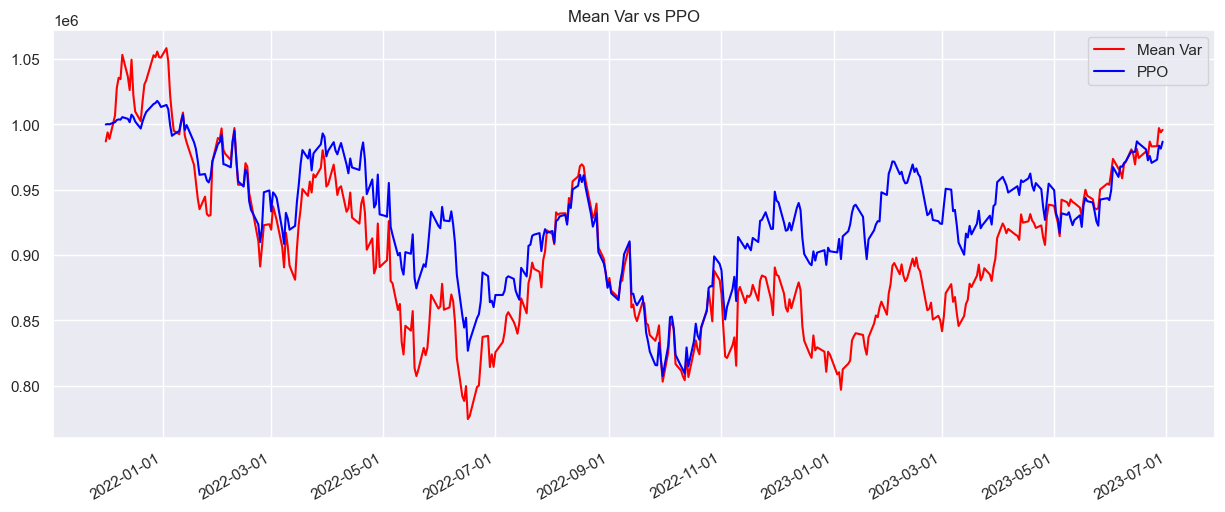

In [59]:
import matplotlib.dates as mdates

result.index = pd.to_datetime(result.index)

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(result.index, result['Mean Var'], color='red', label='Mean Var')
ax.plot(result.index, result['PPO'], color='blue', label='PPO')

ax.set_title('Mean Var vs PPO')

ax.legend(loc='best')

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

fig.autofmt_xdate()

ax.grid(True)

plt.show()